# TODO
- manually set fold column in data based on stratified counts
- test catboost gpu functionality/speed
- Power parameter tuning for tweedie
- Feature interaction + selection
- follow approaches from: https://www.kaggle.com/chandrimad31/claims-severity-analysis-of-models-in-depth
- figure out optimal transform of pure premium to reduce skewness
- adversarial validation of test data
- Surrogate loss functions that are better for Gini

- stacked model: blend(tweedie_stack, freq_sev_stack, claim_ind_stack)

model types:
- pure premium
- binned pure premium
- freq-severity
- hurdle-freq - severity
- hurdle claim cost

Sub component models:
- binary claim_ind
    - Any binary classifier
- reg frequency masked
    - Poisson objective + box_cox
    - Surrogate (mse/mae) objective + box_cox
- reg severity masked
    - Gamma objective
    - Gamma objective + box_cox
    - Surrogate (mse/mae) objective + box_cox
- reg pure premium
    - Tweedie objective
    - Tweedie objective + box_cox on losses
- reg pure premium masked
    - Gamma objective
    - Gamma objective + box_cox
    - Surrogate (mse/mae) objective + box_cox

In [130]:
# Importing packages
from time import time
from functools import partial
from scipy.stats import skew
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.model_selection import RepeatedKFold, cross_val_predict, cross_val_score, RandomizedSearchCV, cross_validate, KFold
from sklearn.base import TransformerMixin, BaseEstimator, RegressorMixin
from sklearn.feature_selection import RFECV
from sklearn.metrics import make_scorer, precision_recall_curve, classification_report, roc_auc_score, mean_poisson_deviance, mean_gamma_deviance, mean_tweedie_deviance
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer, make_column_selector, TransformedTargetRegressor
from sklearn.preprocessing import PowerTransformer, OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.dummy import DummyRegressor, DummyClassifier
from sklearn.linear_model import LogisticRegressionCV, RidgeCV, PoissonRegressor, GammaRegressor, TweedieRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier, StackingRegressor
from sklearn.calibration import CalibratedClassifierCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor, LGBMClassifier
from catboost import CatBoostRegressor
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
import tensorflow as tf

In [135]:
class NonzeroPowerTransformer(PowerTransformer):
    
    def __init__(self, method='box-cox', *, standardize=False, copy=True):
        self.method = method
        self.standardize = standardize
        self.copy = copy

    def fit(self, X, y=None):
        _X = X.copy()
        self._fit(_X[_X > 0.0], y=y, force_transform=False)
        return self

    def fit_transform(self, X, y=None):
        _X = X.copy()
        return self._fit([_X > 0.0], y, force_transform=True)

    def transform(self, X):
        check_is_fitted(self)

        transform_function = {'box-cox': boxcox,
                              'yeo-johnson': self._yeo_johnson_transform
                              }[self.method]
        for i, lmbda in enumerate(self.lambdas_):
            with np.errstate(invalid='ignore'):  # hide NaN warnings
                X[:, i] = np.where(X[:, i] > 0.0, transform_function(X[:, i], lmbda), 0.0)

        if self.standardize:
            X = self._scaler.transform(X)

        return X

    def inverse_transform(self, X):
        check_is_fitted(self)

        if self.standardize:
            X = self._scaler.inverse_transform(X)

        inv_fun = {'box-cox': self._box_cox_inverse_tranform,
                   'yeo-johnson': self._yeo_johnson_inverse_transform
                   }[self.method]
        for i, lmbda in enumerate(self.lambdas_):
            with np.errstate(invalid='ignore'):  # hide NaN warnings
                X[:, i] = np.where(X[:, i] > 0.0, inv_fun(X[:, i], lmbda), 0.0)

        return X

In [110]:
# Importing all our data
df = pd.read_csv('InsNova_train.csv')
df = df.sample(frac=1.0)
df['pure_premium'] = df['claim_cost'] / df['exposure']
df['avg_cost'] = df['claim_cost'] / np.fmax(df['claim_count'], 1)
df['frequency'] = df['claim_count'] / df['exposure']
sev_mask = df['claim_ind'] == 1
response_cols = ['exposure', 'claim_ind', 'claim_count', 'claim_cost', 'pure_premium', 'avg_cost', 'frequency']
X, y = df.drop(response_cols, axis=1), df[response_cols]
X = X.drop('id', axis=1)

# Adding a condensed veh_body column
other_bodies = ['TRUCK', 'COUPE', 'MIBUS', 'PANVN', 'BUS', 'RDSTR', 'MCARA', 'CONVT']
X['veh_body2'] = np.where(X['veh_body'].isin(other_bodies), 'OTHER', X['veh_body'])

# Creating Categorical dataset for LightGBM and CatBoost
for i in ['veh_body', 'veh_body2', 'gender', 'area']:
    X[i] = X[i].astype('category')
X_sev = X[y['claim_cost'] > 0.0]
y_sev = y[y['claim_cost'] > 0.0]
lin_cols = ['veh_body2', 'veh_age', 'gender', 'area', 'dr_age', 'veh_value']
boost_cols = ['veh_value', 'veh_body', 'veh_age', 'gender', 'area', 'dr_age']
    
# Defining column transformers for later steps          
get_cats = make_column_selector(dtype_include=pd.CategoricalDtype)
one_hot = lambda: ColumnTransformer([('one_hot', OneHotEncoder(drop='first', sparse=False), get_cats)], remainder='passthrough')

# Initializing cross validated preds
cv_preds = {}

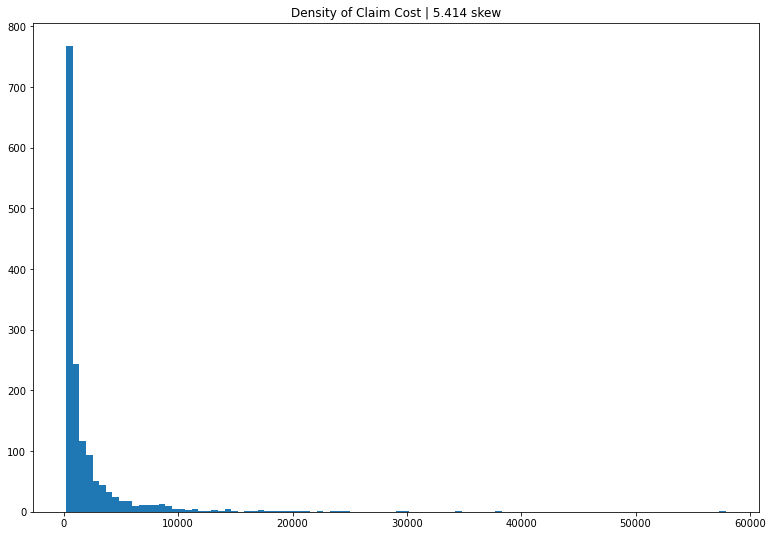

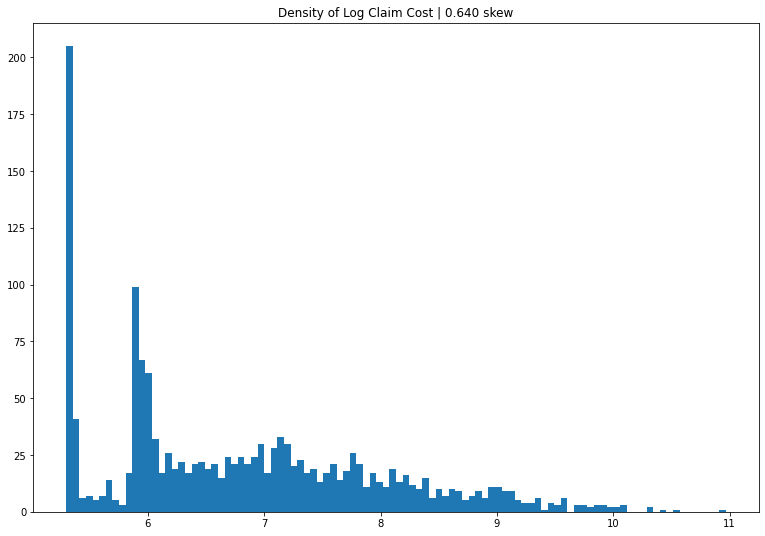

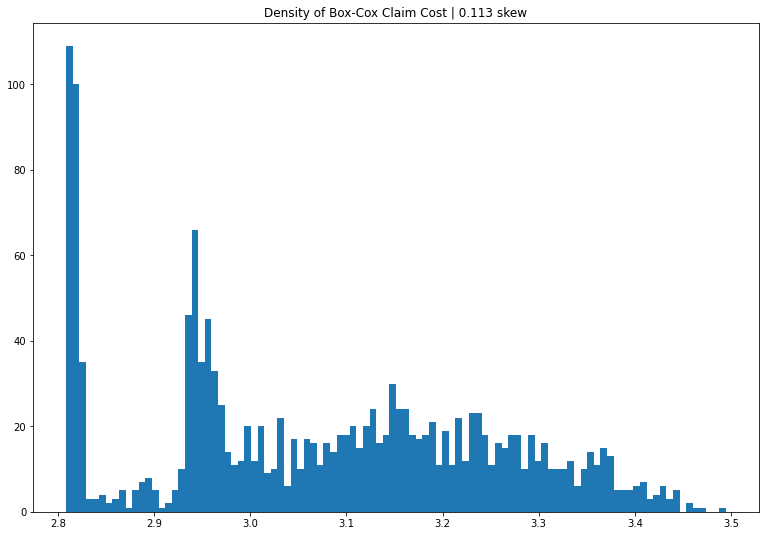

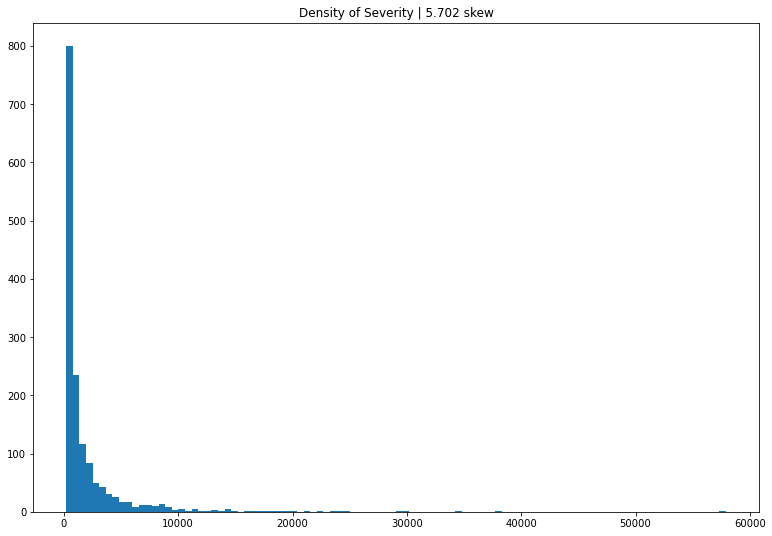

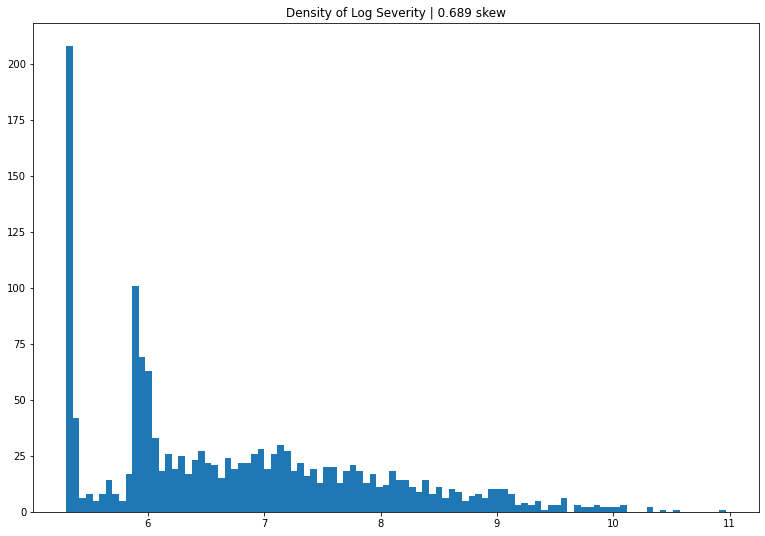

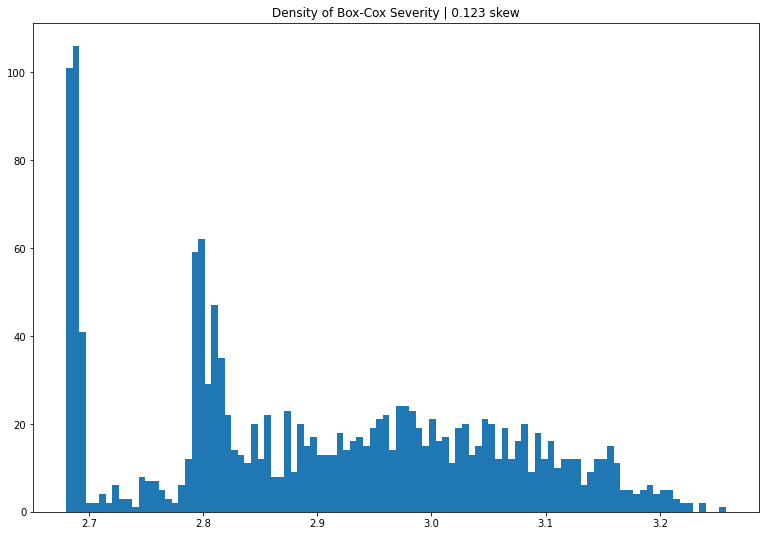

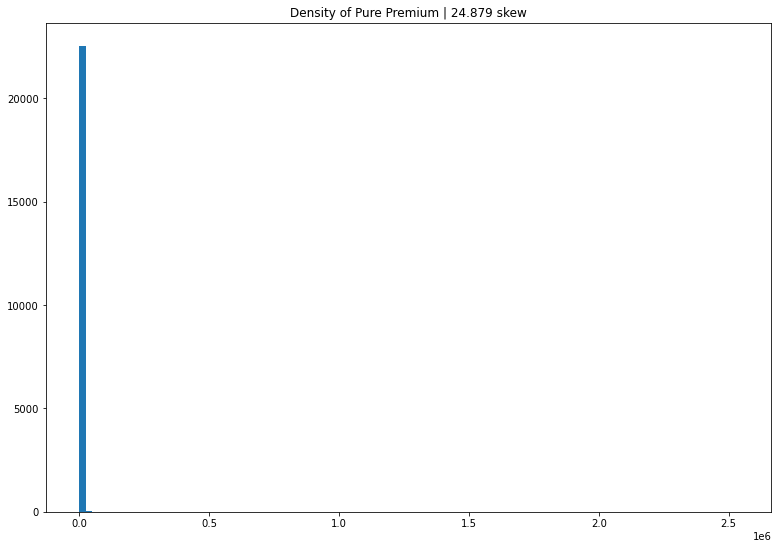

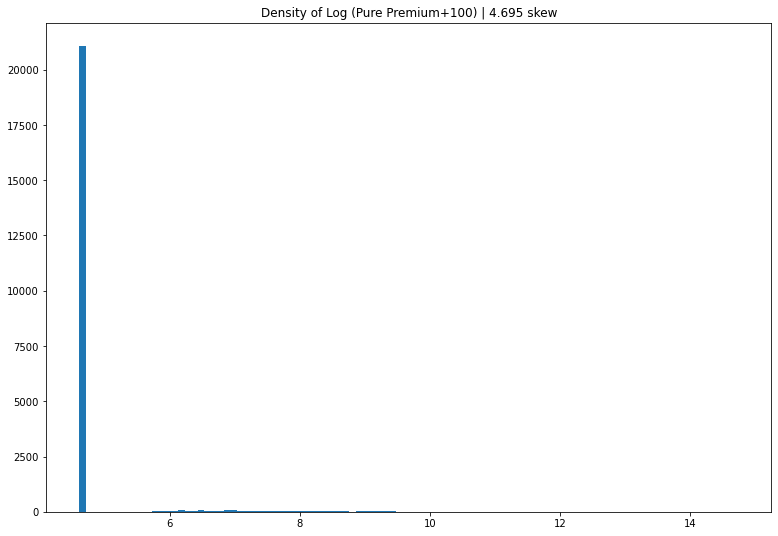

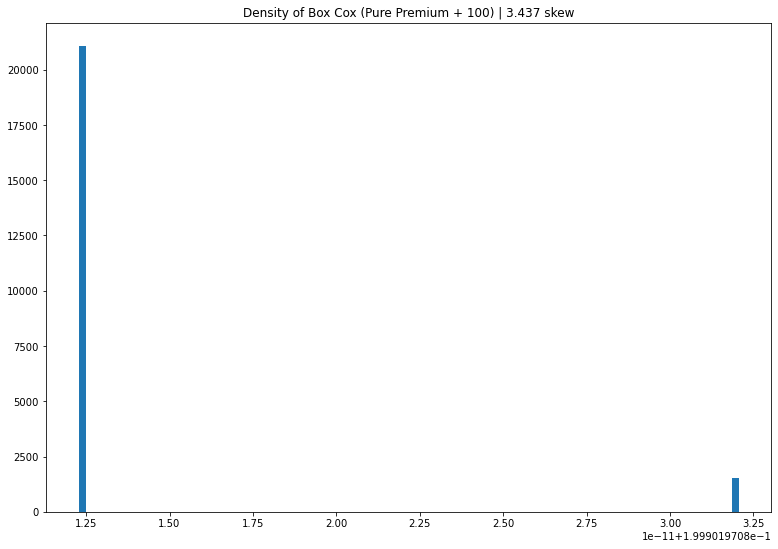

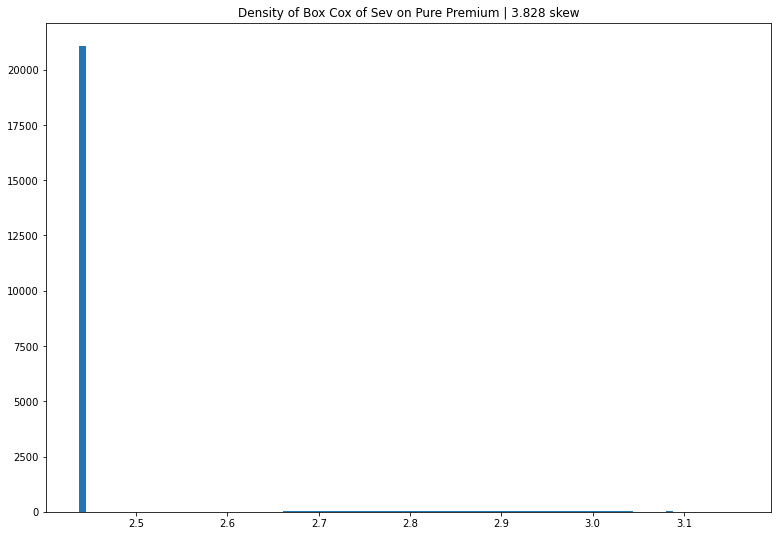

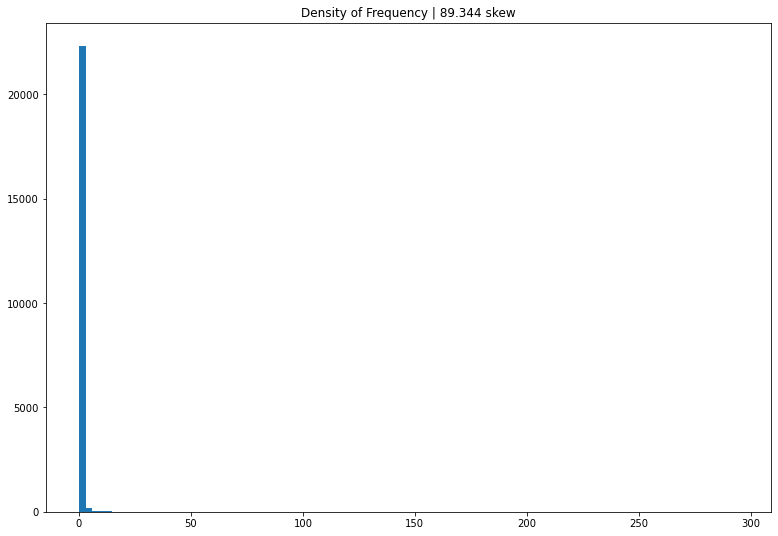

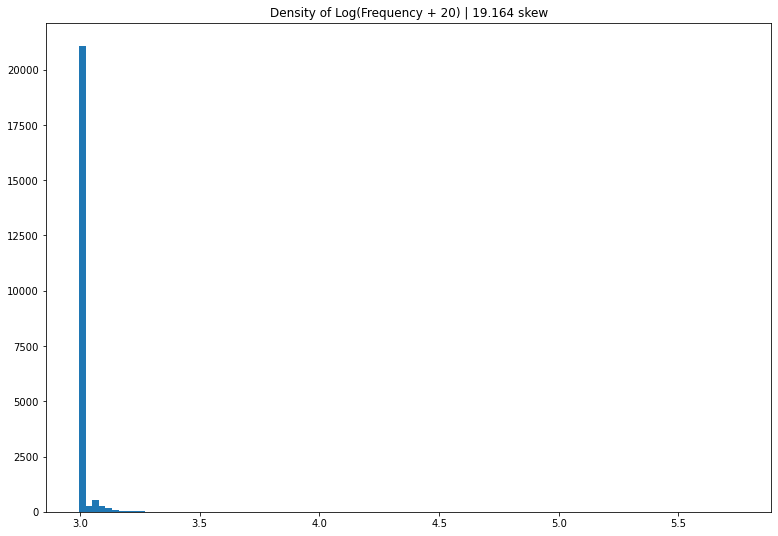

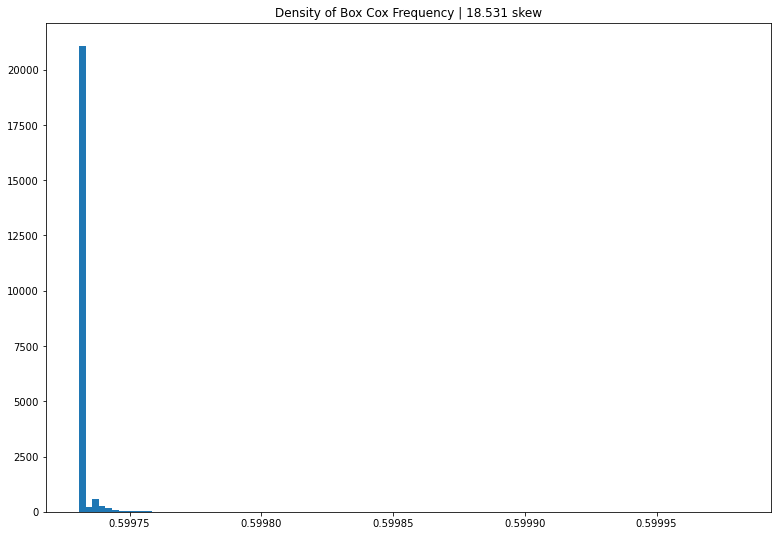

In [116]:
# Looking at responses
# Claim Cost
plt.figure(figsize=(13, 9))
plt.hist(y_sev['claim_cost'], bins=100)
plt.title('Density of Claim Cost | {:.3f} skew'.format(skew(y['claim_cost'][sev_mask])))
plt.show()

# Log Claim Cost
_x = np.log(y_sev['claim_cost'])
plt.figure(figsize=(13, 9))
plt.hist(np.log(y_sev['claim_cost']), bins=100)
plt.title('Density of Log Claim Cost | {:.3f} skew'.format(skew(_x)))
plt.show()

# Box-Cox Claim Cost
_x = power_transform(y_sev['claim_cost'].values.reshape(-1, 1), method='box-cox', standardize=False).flatten()
plt.figure(figsize=(13, 9))
plt.hist(_x, bins=100)
plt.title('Density of Box-Cox Claim Cost | {:.3f} skew'.format(skew(_x)))
plt.show()

# Severity
plt.figure(figsize=(13, 9))
plt.hist(y_sev['avg_cost'], bins=100)
plt.title('Density of Severity | {:.3f} skew'.format(skew(y['avg_cost'][sev_mask])))
plt.show()

# Log severity
_x = np.log(y_sev['avg_cost'])
plt.figure(figsize=(13, 9))
plt.hist(_x, bins=100)
plt.title('Density of Log Severity | {:.3f} skew'.format(skew(_x)))
plt.show()

# Box-Cox severity
_x = power_transform(y_sev['avg_cost'].values.reshape(-1, 1), method='box-cox', standardize=False).flatten()
plt.figure(figsize=(13, 9))
plt.hist(_x, bins=100)
plt.title('Density of Box-Cox Severity | {:.3f} skew'.format(skew(_x)))
plt.show()

# Pure Premium
plt.figure(figsize=(13, 9))
plt.hist(y['pure_premium'], bins=100)
plt.title('Density of Pure Premium | {:.3f} skew'.format(skew(y['pure_premium'][sev_mask])))
plt.show()

# Log Pure Premium + 100
_x = np.log(y['pure_premium'] + 100)
plt.figure(figsize=(13, 9))
plt.hist(_x, bins=100)
plt.title('Density of Log (Pure Premium+100) | {:.3f} skew'.format(skew(_x)))
plt.show()

# Box-Cox Pure Premium + 100
_x = power_transform(y['pure_premium'].values.reshape(-1, 1) + 100, method='box-cox', standardize=False).flatten()
plt.figure(figsize=(13, 9))
plt.hist(_x, bins=100)
plt.title('Density of Box Cox (Pure Premium + 100) | {:.3f} skew'.format(skew(_x)))
plt.show()

# Box-Cox only on claims, applied to all (Pure Premium + 100)
p = PowerTransformer(method='box-cox', standardize=False).fit(y['pure_premium'][sev_mask].values.reshape(-1, 1) + 100)
_x = p.transform(y['pure_premium'].values.reshape(-1, 1) + 100).flatten()
plt.figure(figsize=(13, 9))
plt.hist(_x, bins=100)
plt.title('Density of Box Cox of Sev on Pure Premium | {:.3f} skew'.format(skew(_x)))
plt.show()

# Frequency
plt.figure(figsize=(13, 9))
plt.hist(y['frequency'], bins=100)
plt.title('Density of Frequency | {:.3f} skew'.format(skew(y['frequency'])))
plt.show()

# Log Frequency + 20
_x = np.log(y['frequency'] + 20)
plt.figure(figsize=(13, 9))
plt.hist(_x, bins=100)
plt.title('Density of Log(Frequency + 20) | {:.3f} skew'.format(skew(_x)))
plt.show()

# Box Cox Frequency + 1 (only scale on claims)
p = PowerTransformer(method='box-cox', standardize=False).fit(y['frequency'][sev_mask].values.reshape(-1, 1) + 1)
_x = p.transform(y['frequency'].values.reshape(-1, 1) + 100).flatten()
plt.figure(figsize=(13, 9))
plt.hist(_x, bins=100)
plt.title('Density of Box Cox Frequency | {:.3f} skew'.format(skew(_x)))
plt.show()

# Box-Cox looks to be the best here, tough to transform Tweedie properly though

In [59]:
# Looking at claims
df[df['claim_ind'] == 1].sort_values('claim_cost', ascending=False)

,id,veh_value,exposure,veh_body,veh_age,gender,area,dr_age,claim_ind,claim_count,claim_cost,pure_premium,avg_cost,frequency
5158,15446,5.28,0.173134,STNWG,2,M,A,2,1,1,57895.584560,334398.325326,57895.584560,5.775887
22538,67648,4.90,0.092339,STNWG,1,F,F,2,1,1,37785.261650,409202.123115,37785.261650,10.829676
22562,67717,3.78,0.333892,HDTOP,2,M,F,1,1,1,34460.837510,103209.637522,34460.837510,2.994983
5092,15269,2.34,0.977423,SEDAN,2,M,A,4,1,1,29661.347820,30346.483286,29661.347820,1.023099
16626,49874,1.18,0.538212,SEDAN,3,F,C,2,1,1,29614.535570,55023.916930,29614.535570,1.858004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9630,28902,1.48,0.506591,HBACK,1,F,B,1,1,1,200.072039,394.937817,200.072039,1.973978
5112,15313,1.53,0.323186,SEDAN,3,M,A,5,1,1,200.070740,619.057443,200.070740,3.094193
16501,49510,2.31,0.884337,SEDAN,1,F,C,3,1,1,200.037808,226.200948,200.037808,1.130791
22526,67613,2.49,0.651612,SEDAN,1,F,F,3,1,1,200.003534,306.936747,200.003534,1.534657


In [60]:
# Defining our gini function
def gini(y_true, y_pred):
    # check and get number of samples
    assert y_true.shape == y_pred.shape
    n_samples = y_true.shape[0]
    
    # sort rows on prediction column 
    # (from largest to smallest)
    arr = np.array([y_true, y_pred]).transpose()
    true_order = arr[arr[:,0].argsort()][::-1,0]
    pred_order = arr[arr[:,1].argsort()][::-1,0]
    
    # get Lorenz curves
    L_true = np.cumsum(true_order) / np.fmax(1.0, np.sum(true_order))
    L_pred = np.cumsum(pred_order) / np.fmax(1.0, np.sum(pred_order))
    L_ones = np.linspace(1/n_samples, 1, n_samples)
    
    # get Gini coefficients (area between curves)
    G_true = np.sum(L_ones - L_true)
    G_pred = np.sum(L_ones - L_pred)
    
    # normalize to true Gini coefficient
    return G_pred/G_true

In [61]:
# Defining a function to get cross-validated predictions
def get_cv_preds(model, X, y, fit_params, proba=False):
    return cross_val_predict(model, X, y, fit_params=fit_params, cv=KFold(30), method='predict_proba' if proba else 'predict')
    #preds = []
    #for i in range(5):
    #    _x = cross_val_predict(model, X, y,
    #                           fit_params=fit_params,
    #                           cv=KFold(5, random_state=i),
    #                           method='predict_proba' if proba else 'predict')
    #    if len(_x.shape) == 2:
    #        _x = _x[:, 0]
    #    preds.append(_x)
    #return np.mean(np.vstack(preds), axis=0)

In [5]:
# Logistic Regression for indicator
logit_ind = make_pipeline(one_hot(),
                          StandardScaler(),
                          LogisticRegressionCV(cv=5,
                                               max_iter=1000,
                                               class_weight='balanced'))
cv_preds['logit_ind'] = get_cv_preds(logit_ind,
                                     X.drop('veh_body', axis=1),
                                     y['claim_ind'],
                                     {'logisticregressioncv__sample_weight': y['exposure']},
                                     True)
logit_ind.fit(X.drop('veh_body', axis=1), y['claim_ind'], logisticregressioncv__sample_weight=y['exposure'])
print(classification_report(y['claim_ind'], logit_ind.predict_proba(X.drop('veh_body', axis=1))[:, 1] > 0.5))
print(classification_report(y['claim_ind'], cv_preds['logit_ind'][:, 1] > 0.5))

              precision    recall  f1-score   support

           0       0.95      0.08      0.15     21076
           1       0.07      0.94      0.13      1534

    accuracy                           0.14     22610
   macro avg       0.51      0.51      0.14     22610
weighted avg       0.89      0.14      0.15     22610

              precision    recall  f1-score   support

           0       0.95      0.09      0.16     21076
           1       0.07      0.94      0.13      1534

    accuracy                           0.14     22610
   macro avg       0.51      0.51      0.14     22610
weighted avg       0.89      0.14      0.15     22610



In [6]:
# Naive bayes
nb_ind = make_pipeline(one_hot(),
                          StandardScaler(),
                          BernoulliNB())
cv_preds['nb_ind'] = get_cv_preds(nb_ind,
                                     X.drop('veh_body', axis=1),
                                     y['claim_ind'],
                                     {'bernoullinb__sample_weight': y['exposure']},
                                     True)
nb_ind.fit(X.drop('veh_body', axis=1), y['claim_ind'], bernoullinb__sample_weight=y['exposure'])
print(classification_report(y['claim_ind'], nb_ind.predict_proba(X.drop('veh_body', axis=1))[:, 1] > 0.5))
print(classification_report(y['claim_ind'], cv_preds['nb_ind'][:, 1] > 0.5))

              precision    recall  f1-score   support

           0       0.95      0.08      0.14     21076
           1       0.07      0.95      0.13      1534

    accuracy                           0.14     22610
   macro avg       0.51      0.51      0.14     22610
weighted avg       0.89      0.14      0.14     22610

              precision    recall  f1-score   support

           0       0.94      0.09      0.16     21076
           1       0.07      0.93      0.13      1534

    accuracy                           0.14     22610
   macro avg       0.51      0.51      0.14     22610
weighted avg       0.88      0.14      0.15     22610



In [8]:
# SVC
"""
svc_ind = make_pipeline(one_hot(),
                          StandardScaler(),
                          SVC(probability=True, class_weight='balanced'))
cv_preds['svc_ind'] = get_cv_preds(svc_ind,
                                   X.drop('veh_body', axis=1),
                                   y['claim_ind'],
                                   {'svc__sample_weight': y['exposure']},
                                   True)
svc_ind.fit(X.drop('veh_body', axis=1), y['claim_ind'], svc__sample_weight=y['exposure'])
print(classification_report(y['claim_ind'], svc_ind.predict_proba(X.drop('veh_body', axis=1))[:, 0] > 0.5))
print(classification_report(y['claim_ind'], cv_preds['svc_ind'][:, 0] > 0.5))
"""

"\nsvc_ind = make_pipeline(one_hot(),\n                          StandardScaler(),\n                          SVC(probability=True, class_weight='balanced'))\ncv_preds['svc_ind'] = get_cv_preds(svc_ind,\n                                   X.drop('veh_body', axis=1),\n                                   y['claim_ind'],\n                                   {'svc__sample_weight': y['exposure']},\n                                   True)\nsvc_ind.fit(X.drop('veh_body', axis=1), y['claim_ind'], svc__sample_weight=y['exposure'])\nprint(classification_report(y['claim_ind'], svc_ind.predict_proba(X.drop('veh_body', axis=1))[:, 0] > 0.5))\nprint(classification_report(y['claim_ind'], cv_preds['svc_ind'][:, 0] > 0.5))\n"

In [7]:
# KNN
knn_ind = make_pipeline(one_hot(),
                        StandardScaler(),
                        KNeighborsClassifier(n_jobs=-1))
cv_preds['knn_ind'] = get_cv_preds(knn_ind,
                                   X.drop('veh_body', axis=1),
                                   y['claim_ind'],
                                   {},
                                   True)
knn_ind.fit(X.drop('veh_body', axis=1), y['claim_ind'])
print(classification_report(y['claim_ind'], knn_ind.predict_proba(X.drop('veh_body', axis=1))[:, 1] > 0.5))
print(classification_report(y['claim_ind'], cv_preds['knn_ind'][:, 1] > 0.5))

              precision    recall  f1-score   support

           0       0.93      1.00      0.97     21076
           1       0.69      0.02      0.04      1534

    accuracy                           0.93     22610
   macro avg       0.81      0.51      0.50     22610
weighted avg       0.92      0.93      0.90     22610

              precision    recall  f1-score   support

           0       0.93      1.00      0.96     21076
           1       0.01      0.00      0.00      1534

    accuracy                           0.93     22610
   macro avg       0.47      0.50      0.48     22610
weighted avg       0.87      0.93      0.90     22610



In [11]:
# MLP
mlp_ind = make_pipeline(one_hot(),
                        StandardScaler(),
                        MLPClassifier(max_iter=75))
cv_preds['mlp_ind'] = get_cv_preds(mlp_ind,
                                   X.drop('veh_body', axis=1),
                                   y['claim_ind'],
                                   {},
                                   True)
mlp_ind.fit(X.drop('veh_body', axis=1), y['claim_ind'])
print(classification_report(y['claim_ind'], mlp_ind.predict_proba(X.drop('veh_body', axis=1))[:, 1] > 0.5))
print(classification_report(y['claim_ind'], cv_preds['mlp_ind'][:, 1] > 0.5))

C:\Users\gursk\anaconda3\envs\travelers\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (75) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\gursk\anaconda3\envs\travelers\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (75) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\gursk\anaconda3\envs\travelers\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (75) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\gursk\anaconda3\envs\travelers\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (75) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\gursk\a

              precision    recall  f1-score   support

           0       0.93      1.00      0.96     21076
           1       0.00      0.00      0.00      1534

    accuracy                           0.93     22610
   macro avg       0.47      0.50      0.48     22610
weighted avg       0.87      0.93      0.90     22610

              precision    recall  f1-score   support

           0       0.93      1.00      0.96     21076
           1       0.00      0.00      0.00      1534

    accuracy                           0.93     22610
   macro avg       0.47      0.50      0.48     22610
weighted avg       0.87      0.93      0.90     22610



C:\Users\gursk\anaconda3\envs\travelers\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (75) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\gursk\anaconda3\envs\travelers\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [8]:
# Sklearn Random Forest
skrf_ind = make_pipeline(one_hot(),
                          RandomForestClassifier(n_estimators=1000,
                                                 max_leaf_nodes=21,
                                                 class_weight='balanced',
                                                 n_jobs=-1))
cv_preds['skrf_ind'] = get_cv_preds(skrf_ind,
                                   X.drop('veh_body2', axis=1),
                                   y['claim_ind'],
                                   {'randomforestclassifier__sample_weight': y['exposure']},
                                   True)
skrf_ind.fit(X.drop('veh_body2', axis=1), y['claim_ind'], randomforestclassifier__sample_weight=y['exposure'])
print(classification_report(y['claim_ind'], skrf_ind.predict_proba(X.drop('veh_body2', axis=1))[:, 1] > 0.5))
print(classification_report(y['claim_ind'], cv_preds['skrf_ind'][:, 1] > 0.5))

              precision    recall  f1-score   support

           0       1.00      0.00      0.00     21076
           1       0.07      1.00      0.13      1534

    accuracy                           0.07     22610
   macro avg       0.53      0.50      0.07     22610
weighted avg       0.94      0.07      0.01     22610

              precision    recall  f1-score   support

           0       0.97      0.00      0.00     21076
           1       0.07      1.00      0.13      1534

    accuracy                           0.07     22610
   macro avg       0.52      0.50      0.07     22610
weighted avg       0.91      0.07      0.01     22610



In [9]:
# Sklearn GBM
gbm_ind = make_pipeline(one_hot(),
                        GradientBoostingClassifier(n_estimators=500,
                                                   learning_rate=0.01,
                                                   subsample=0.67,
                                                   max_leaf_nodes=21))
cv_preds['gbm_ind'] = get_cv_preds(gbm_ind,
                                   X.drop('veh_body2', axis=1),
                                   y['claim_ind'],
                                   {'gradientboostingclassifier__sample_weight': y['exposure']},
                                   True)
gbm_ind.fit(X.drop('veh_body2', axis=1), y['claim_ind'], gradientboostingclassifier__sample_weight=y['exposure'])
print(classification_report(y['claim_ind'], gbm_ind.predict_proba(X.drop('veh_body2', axis=1))[:, 1] > 0.5))
print(classification_report(y['claim_ind'], cv_preds['gbm_ind'][:, 1] > 0.5))

              precision    recall  f1-score   support

           0       0.98      0.16      0.28     21076
           1       0.08      0.95      0.14      1534

    accuracy                           0.22     22610
   macro avg       0.53      0.55      0.21     22610
weighted avg       0.92      0.22      0.27     22610

              precision    recall  f1-score   support

           0       0.94      0.17      0.29     21076
           1       0.07      0.85      0.13      1534

    accuracy                           0.22     22610
   macro avg       0.51      0.51      0.21     22610
weighted avg       0.88      0.22      0.28     22610



In [10]:
# Sklearn HistGBM
hgbm_ind = make_pipeline(one_hot(),
                         HistGradientBoostingClassifier(max_iter=500,
                                                        learning_rate=0.01,
                                                        max_leaf_nodes=21))
cv_preds['hgbm_ind'] = get_cv_preds(hgbm_ind,
                                   X.drop('veh_body2', axis=1),
                                   y['claim_ind'],
                                   {'histgradientboostingclassifier__sample_weight': y['exposure']},
                                   True)
hgbm_ind.fit(X.drop('veh_body2', axis=1), y['claim_ind'], histgradientboostingclassifier__sample_weight=y['exposure'])
print(classification_report(y['claim_ind'], hgbm_ind.predict_proba(X.drop('veh_body2', axis=1))[:, 1] > 0.5))
print(classification_report(y['claim_ind'], cv_preds['hgbm_ind'][:, 1] > 0.5))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     21076
           1       0.07      1.00      0.13      1534

    accuracy                           0.07     22610
   macro avg       0.03      0.50      0.06     22610
weighted avg       0.00      0.07      0.01     22610

              precision    recall  f1-score   support

           0       0.94      0.03      0.06     21076
           1       0.07      0.97      0.13      1534

    accuracy                           0.10     22610
   macro avg       0.50      0.50      0.09     22610
weighted avg       0.88      0.10      0.07     22610



C:\Users\gursk\anaconda3\envs\travelers\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [13]:
# Autosklearn
"""
AutoSklearn2Classifier
auto_ind = make_pipeline(one_hot(),
                        StandardScaler(),
                        AutoSklearn2Classifier(n_jobs=-1))
cv_preds['auto_ind'] = get_cv_preds(auto_ind,
                                   X.drop('veh_body2', axis=1),
                                   y['claim_ind'],
                                   {},
                                   True)
auto_ind.fit(X.drop('veh_body2', axis=1), y['claim_ind'])
print(classification_report(y['claim_ind'], auto_ind.predict_proba(X.drop('veh_body', axis=1))[:, 0] > 0.5))
print(classification_report(y['claim_ind'], cv_preds['auto_ind'][:, 0] > 0.5))
"""

"\nAutoSklearn2Classifier\nauto_ind = make_pipeline(one_hot(),\n                        StandardScaler(),\n                        AutoSklearn2Classifier(n_jobs=-1))\ncv_preds['auto_ind'] = get_cv_preds(auto_ind,\n                                   X.drop('veh_body2', axis=1),\n                                   y['claim_ind'],\n                                   {},\n                                   True)\nauto_ind.fit(X.drop('veh_body2', axis=1), y['claim_ind'])\nprint(classification_report(y['claim_ind'], auto_ind.predict_proba(X.drop('veh_body', axis=1))[:, 0] > 0.5))\nprint(classification_report(y['claim_ind'], cv_preds['auto_ind'][:, 0] > 0.5))\n"

In [11]:
# Lightgbm to predict if any claims
rf_ind = LGBMClassifier(n_estimators=1000,
                          num_leaves=21,
                          learning_rate=1.0,
                          colsample_bytree=5 / 7,
                          subsample=0.67,
                          subsample_freq=1,
                          is_unbalance=True,
                          objective='binary',
                          n_jobs=1)
cv_preds['rf_ind'] = get_cv_preds(rf_ind,
                                   X.drop('veh_body2', axis=1),
                                   y['claim_ind'],
                                   {'sample_weight': y['exposure']},
                                   True)
rf_ind.fit(X.drop('veh_body2', axis=1), y['claim_ind'], sample_weight=y['exposure'])
print(classification_report(y['claim_ind'], rf_ind.predict_proba(X.drop('veh_body2', axis=1))[:, 1] > 0.5))
print(classification_report(y['claim_ind'], cv_preds['rf_ind'][:, 1] > 0.5))

              precision    recall  f1-score   support

           0       0.94      0.03      0.05     21076
           1       0.07      0.97      0.13      1534

    accuracy                           0.09     22610
   macro avg       0.50      0.50      0.09     22610
weighted avg       0.88      0.09      0.06     22610

              precision    recall  f1-score   support

           0       0.93      0.11      0.20     21076
           1       0.07      0.88      0.12      1534

    accuracy                           0.16     22610
   macro avg       0.50      0.49      0.16     22610
weighted avg       0.87      0.16      0.19     22610



In [12]:
# Lightgbm to predict if any claims
lgbm_ind = LGBMClassifier(n_estimators=1000,
                          num_leaves=21,
                          learning_rate=0.001,
                          colsample_bytree=6 / 7,
                          subsample=0.67,
                          subsample_freq=1,
                          is_unbalance=True,
                          objective='binary',
                          n_jobs=-1)
cv_preds['lgbm_ind'] = get_cv_preds(lgbm_ind,
                                   X.drop('veh_body', axis=1),
                                   y['claim_ind'],
                                   {'sample_weight': y['exposure']},
                                   True)
lgbm_ind.fit(X.drop('veh_body', axis=1), y['claim_ind'], sample_weight=y['exposure'])
print(classification_report(y['claim_ind'], lgbm_ind.predict_proba(X.drop('veh_body', axis=1))[:, 1] > 0.5))
print(classification_report(y['claim_ind'], cv_preds['lgbm_ind'][:, 1] > 0.5))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     21076
           1       0.07      1.00      0.13      1534

    accuracy                           0.07     22610
   macro avg       0.03      0.50      0.06     22610
weighted avg       0.00      0.07      0.01     22610

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     21076
           1       0.07      1.00      0.13      1534

    accuracy                           0.07     22610
   macro avg       0.03      0.50      0.06     22610
weighted avg       0.00      0.07      0.01     22610



C:\Users\gursk\anaconda3\envs\travelers\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [13]:
# Blending under a logistic regression
df_cv_ind = pd.DataFrame({k:v[:,0] for k, v in cv_preds.items() if 'ind' in k})
X_cv_ind = df_cv_ind#pd.concat([X, df_cv_ind], axis=1)
print(X_cv_ind)

       logit_ind    nb_ind  knn_ind  skrf_ind   gbm_ind  hgbm_ind  rf_ind  \
0       0.455165  0.478205      1.0  0.058891  0.440032  0.434508     0.0   
1       0.448060  0.468983      0.8  0.056833  0.438607  0.411467     0.0   
2       0.475441  0.456543      1.0  0.083673  0.511039  0.422974     0.0   
3       0.515580  0.452417      1.0  0.160466  0.595769  0.500431     0.0   
4       0.436664  0.411333      1.0  0.055239  0.446389  0.423618     0.0   
...          ...       ...      ...       ...       ...       ...     ...   
22605   0.456694  0.467226      1.0  0.063185  0.471258  0.415194     0.0   
22606   0.415203  0.449931      1.0  0.052505  0.418155  0.425172     0.0   
22607   0.503356  0.463175      1.0  0.062243  0.432579  0.444597     0.0   
22608   0.501284  0.492906      1.0  0.071490  0.522225  0.438679     0.0   
22609   0.404010  0.376656      0.8  0.050536  0.377585  0.430249     0.0   

       lgbm_ind  
0      0.193179  
1      0.190624  
2      0.208058  
3  

In [14]:
# Blending model with logistic regression
stacked_ind = make_pipeline(one_hot(),
                            StandardScaler(),
                            LogisticRegressionCV(cv=10,
                                                 max_iter=1000,
                                                 class_weight='balanced',
                                                 n_jobs=-1))
stacked_preds = get_cv_preds(stacked_ind,
                             X_cv_ind,
                             y['claim_ind'],
                             {'logisticregressioncv__sample_weight': y['exposure']},
                             True)
stacked_ind.fit(X_cv_ind, y['claim_ind'], logisticregressioncv__sample_weight=y['exposure'])
print(classification_report(y['claim_ind'], stacked_ind.predict_proba(X_cv_ind)[:, 1] > 0.5))
print(classification_report(y['claim_ind'], stacked_preds[:, 1] > 0.5))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     21076
           1       0.07      1.00      0.13      1534

    accuracy                           0.07     22610
   macro avg       0.03      0.50      0.06     22610
weighted avg       0.00      0.07      0.01     22610

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     21076
           1       0.07      1.00      0.13      1534

    accuracy                           0.07     22610
   macro avg       0.03      0.50      0.06     22610
weighted avg       0.00      0.07      0.01     22610



C:\Users\gursk\anaconda3\envs\travelers\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [15]:
stacked_ind.named_steps['logisticregressioncv'].C_

array([0.0001])

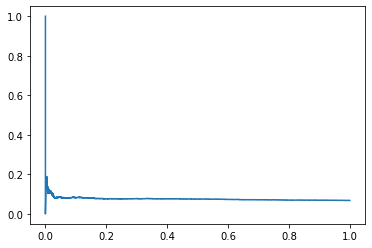

In [16]:
precision, recall, thresholds = precision_recall_curve(y['claim_ind'], stacked_preds[:, 1])
plt.figure()
plt.plot(recall, precision)
plt.show()

In [63]:
# Our base estimators don't seem to be good enough, let's try an hparam tuned LightGBM model
params = {'n_estimators': Integer(2000, 6000),
          'learning_rate': Real(1e-3, 4.0, 'uniform'),
          'num_leaves': Integer(16, 41),
          'min_split_gain': Real(0.0, 10.0, 'uniform'),
          'subsample': Real(0.7, 1.0, 'uniform'),
          'reg_lambda': Real(0.0, 10.0, 'uniform')}
hparam_lgbm_ind = LGBMClassifier(scale_pos_weight=1 / y['claim_ind'].mean(),
                                 subsample_freq=1,
                                 objective='binary',
                                 n_jobs=-1)
lgbm_ind_opt = BayesSearchCV(hparam_lgbm_ind,
                             params,
                             cv=20,
                             fit_params={'sample_weight': y['exposure']},
                             n_iter=32,
                             n_jobs=1,
                             verbose=1)
lgbm_ind_opt.fit(X.drop('veh_body2', axis=1), y['claim_ind'])
lgbm_opt_preds = get_cv_preds(lgbm_ind_opt.best_estimator_,
                              X.drop('veh_body2', axis=1),
                              y['claim_ind'],
                              {'sample_weight': y['exposure']},
                              True)
print(classification_report(y['claim_ind'], lgbm_ind_opt.best_estimator_.predict_proba(X.drop('veh_body2', axis=1))[:, 1] > 0.5))
print(classification_report(y['claim_ind'], lgbm_opt_preds[:, 1] > 0.5))

Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  2.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  1.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  1.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  1.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  3.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  2.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  2.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   28.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  3.0min finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   59.5s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  1.4min finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  2.1min finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  2.0min finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   26.5s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   42.7s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  2.5min finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  2.0min finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  1.4min finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  1.2min finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  1.6min finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  4.2min finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  4.3min finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  4.6min finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  3.7min finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  3.7min finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  3.7min finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  2.9min finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  2.3min finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  2.0min finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  2.0min finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  2.2min finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  4.0min finished


              precision    recall  f1-score   support

           0       1.00      0.95      0.98     21076
           1       0.60      1.00      0.75      1534

    accuracy                           0.95     22610
   macro avg       0.80      0.98      0.86     22610
weighted avg       0.97      0.95      0.96     22610

              precision    recall  f1-score   support

           0       0.93      0.90      0.92     21076
           1       0.07      0.10      0.08      1534

    accuracy                           0.85     22610
   macro avg       0.50      0.50      0.50     22610
weighted avg       0.87      0.85      0.86     22610



In [64]:
print(lgbm_ind_opt.best_params_)
"""
OrderedDict([('learning_rate', 0.49068254256963156), ('min_split_gain', 0.0), ('n_estimators', 3316), ('num_leaves', 41), ('reg_lambda', 5.171433881715265), ('subsample', 0.9977600459125546)])
"""

OrderedDict([('learning_rate', 0.49068254256963156), ('min_split_gain', 0.0), ('n_estimators', 3316), ('num_leaves', 41), ('reg_lambda', 5.171433881715265), ('subsample', 0.9977600459125546)])


"\nOrderedDict([('learning_rate', 0.32341711357435404),\n('min_split_gain', 3.220005862962977),\n('n_estimators', 3529),\n('num_leaves', 33),\n('reg_lambda', 1.3829943034439782),\n('subsample', 0.7)])\n"

In [73]:
pd.DataFrame({'label':y['claim_ind'], 'pred':lgbm_opt_preds[:,1]}).sort_values('label', ascending=False)

,label,pred
9653,1,1.146627e-07
9612,1,5.408927e-04
21318,1,4.685413e-08
16307,1,9.983184e-03
9664,1,1.637296e-03
...,...,...
8218,0,5.843974e-01
3899,0,4.093532e-04
21510,0,4.886143e-03
5905,0,5.662513e-01


In [62]:
# What if we apply calibration? (Need to fix lgbm)
"""
from sklearn.base import clone, ClassifierMixin
from sklearn.preprocessing import OrdinalEncoder
encode = ColumnTransformer([('encode', OrdinalEncoder(dtype=np.int32), get_cats)], remainder='passthrough')

class PandaLGBMClassifier(BaseEstimator, ClassifierMixin):
    
    def __init__(self, cat_cols, model):
        self.cat_cols = cat_cols
        self.model = model
    
    def fit(self, X, y, sample_weight=None):
        _X = pd.DataFrame(np.array(X))
        for i in self.cat_cols:
            _X[_X.columns[i]] = _X[_X.columns[i]].astype('int32').astype('category')
        self.model.fit(_X, y, sample_weight=sample_weight)
        self.classes_ = self.model.classes_
        return self
    
    def predict(self, X, y=None):
        _X = pd.DataFrame(np.array(X))
        for i in self.cat_cols:
            _X[_X.columns[i]] = _X[_X.columns[i]].astype('int32').astype('category')
        return self.model.predict(_X)
    
    def predict_proba(self, X, y=None):
        _X = pd.DataFrame(np.array(X))
        for i in self.cat_cols:
            _X[_X.columns[i]] = _X[_X.columns[i]].astype('int32').astype('category')
        return self.model.predict_proba(_X)

cal_base = PandaLGBMClassifier([1, 3, 4], clone(lgbm_ind_opt.best_estimator_))
cal_lgbm_ind = make_pipeline(encode, CalibratedClassifierCV(cal_base, cv=10))
cal_lgbm_ind.fit(X.drop('veh_body2', axis=1), y['claim_ind'], calibratedclassifiercv__sample_weight=y['exposure'])
cal_lgbm_ind_preds = get_cv_preds(cal_lgbm_ind,
                                  X.drop('veh_body2', axis=1),
                                  y['claim_ind'],
                                  {'calibratedclassifiercv__sample_weight': y['exposure']},
                                  True)
print(classification_report(y['claim_ind'], cal_lgbm_ind.predict_proba(X.drop('veh_body2', axis=1))[:, 1] > 0.5))
print(classification_report(y['claim_ind'], cal_lgbm_ind_preds[:, 1] > 0.5))
"""

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     21076
           1       0.07      1.00      0.13      1534

    accuracy                           0.07     22610
   macro avg       0.03      0.50      0.06     22610
weighted avg       0.00      0.07      0.01     22610

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     21076
           1       0.07      1.00      0.13      1534

    accuracy                           0.07     22610
   macro avg       0.03      0.50      0.06     22610
weighted avg       0.00      0.07      0.01     22610



C:\Users\gursk\anaconda3\envs\travelers\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Claim Frequency

In [200]:
# Poisson regression
poisson = make_pipeline(ColumnTransformer([('one_hot', OneHotEncoder(drop='first', sparse=False), get_cats)], remainder='passthrough'),
                        StandardScaler(),
                        PoissonRegressor(max_iter=1000))
cv_preds['poisson'] = get_cv_preds(poisson,
                                   X[lin_cols],
                                   y['frequency'],
                                   {'poissonregressor__sample_weight': y['exposure']})
poisson.fit(X[lin_cols], y['frequency'], poissonregressor__sample_weight=y['exposure'])
print(mean_poisson_deviance(y['frequency'], poisson.predict(X[lin_cols])))
print(mean_poisson_deviance(y['frequency'], cv_preds['poisson']))

1.3461190318688971
1.346693318455726


In [248]:
# RF Poisson
rf_poisson = LGBMRegressor(n_estimators=1000,
                           learning_rate=1.0,
                           num_leaves=21,
                           colsample_bytree=5 / 7,
                           subsample=0.67, 
                           subsample_freq=1,
                           boosting_type='rf',
                           objective='poisson',
                           extra_trees=True,
                           mc=[1,0,1,0,0,-1],
                           mc_method='advanced',
                           n_jobs=-1)
cv_preds['rf_poisson'] = get_cv_preds(rf_poisson,
                                      X.drop('veh_body2', axis=1),
                                      y['frequency'],
                                      {'sample_weight': y['exposure']})
rf_poisson.fit(X.drop('veh_body2', axis=1), y['frequency'], sample_weight=y['exposure'])
print(mean_poisson_deviance(y['frequency'], rf_poisson.predict(X.drop('veh_body2', axis=1))))
print(mean_poisson_deviance(y['frequency'], cv_preds['rf_poisson']))              

1.3442226223251375
1.3477648817230947


In [249]:
# LGBM Poisson
lgbm_poisson = LGBMRegressor(n_estimators=1000,
                             learning_rate=0.001,
                             num_leaves=11,
                             objective='poisson',
                             subsample=0.85, 
                             subsample_freq=1,
                             min_split_gain=5.0,
                             mc=[1,0,1,0,0,-1],
                             mc_method='advanced',
                             n_jobs=-1)
cv_preds['lgbm_poisson'] = get_cv_preds(lgbm_poisson,
                                      X.drop('veh_body2', axis=1),
                                      y['frequency'],
                                      {'sample_weight': y['exposure']})
lgbm_poisson.fit(X.drop('veh_body2', axis=1), y['frequency'], sample_weight=y['exposure'])
print(mean_poisson_deviance(y['frequency'], lgbm_poisson.predict(X.drop('veh_body2', axis=1))))
print(mean_poisson_deviance(y['frequency'], cv_preds['lgbm_poisson']))              

1.3437753857859842
1.3456909552524576


In [250]:
# XGBoost Poisson
xgb_poisson = make_pipeline(ColumnTransformer([('one_hot', OneHotEncoder(drop='first', sparse=False), get_cats)], remainder='passthrough'),
                    XGBRegressor(n_estimators=500,
                                 learning_rate=0.01,
                                 max_depth=4,
                                 subsample=0.85, 
                                 objective='count:poisson',
                                 tree_method='hist',
                                 n_jobs=-1))
cv_preds['xgb_poisson'] = get_cv_preds(xgb_poisson,
                                      X.drop('veh_body2', axis=1),
                                      y['frequency'],
                                      {'xgbregressor__sample_weight': y['exposure']})
xgb_poisson.fit(X.drop('veh_body2', axis=1), y['frequency'], xgbregressor__sample_weight=y['exposure'])
print(mean_poisson_deviance(y['frequency'], xgb_poisson.predict(X.drop('veh_body2', axis=1))))
print(mean_poisson_deviance(y['frequency'], cv_preds['xgb_poisson']))      

1.3194315814798911
1.3410476262531628


In [176]:
X_sev

,veh_value,veh_body,veh_age,gender,area,dr_age,veh_body2,log_veh_value
19421,2.02,SEDAN,2,M,D,5,SEDAN,0.703098
5169,1.28,SEDAN,3,F,A,2,SEDAN,0.246860
9766,0.33,HBACK,4,F,B,3,HBACK,0.000000
16723,1.35,HBACK,2,M,C,4,HBACK,0.300105
22568,1.88,SEDAN,2,F,F,4,SEDAN,0.631272
...,...,...,...,...,...,...,...,...
5356,0.58,SEDAN,4,M,A,2,SEDAN,0.000000
16618,1.45,STNWG,4,F,C,2,STNWG,0.371564
19344,1.38,PANVN,4,F,D,3,OTHER,0.322083
9837,2.03,TRUCK,3,M,B,2,OTHER,0.708036


# Claim Severity

In [122]:
# Gamma regression
gamma_sev = make_pipeline(ColumnTransformer([('one_hot', OneHotEncoder(drop='first', sparse=False), get_cats)], remainder='passthrough'),
                          StandardScaler(),
                          GammaRegressor(alpha=5, max_iter=1000))
cv_preds['gamma_sev'] = get_cv_preds(gamma_sev,
                                     X_sev[lin_cols],
                                     y_sev['avg_cost'],
                                     {'gammaregressor__sample_weight': y_sev['exposure']})
gamma_sev.fit(X_sev[lin_cols], y_sev['avg_cost'], gammaregressor__sample_weight=y_sev['exposure'])
print(mean_gamma_deviance(y_sev['avg_cost'], gamma_sev.predict(X_sev[lin_cols])))
print(mean_gamma_deviance(y_sev['avg_cost'], cv_preds['gamma_sev']))
print(np.mean((y_sev['avg_cost'] - gamma_sev.predict(X_sev[lin_cols])) ** 2))
print(np.mean((y_sev['avg_cost'] - cv_preds['gamma_sev']) ** 2))

1.6227206533835246
1.639608486435652
13965378.487190872
14016625.909728115


In [123]:
# Gamma regression
bcgamma_sev = make_pipeline(ColumnTransformer([('one_hot', OneHotEncoder(drop='first', sparse=False), get_cats)], remainder='passthrough'),
                          StandardScaler(),
                          TransformedTargetRegressor(GammaRegressor(alpha=5, max_iter=1000),
                                                     transformer=PowerTransformer(method='box-cox', standardize=False)))
cv_preds['bcgamma_sev'] = get_cv_preds(bcgamma_sev,
                                     X_sev[lin_cols],
                                     y_sev['avg_cost'],
                                     {'transformedtargetregressor__sample_weight': y_sev['exposure']})
bcgamma_sev.fit(X_sev[lin_cols], y_sev['avg_cost'], transformedtargetregressor__sample_weight=y_sev['exposure'])
print(mean_gamma_deviance(y_sev['avg_cost'], bcgamma_sev.predict(X_sev[lin_cols])))
print(mean_gamma_deviance(y_sev['avg_cost'], cv_preds['bcgamma_sev']))
print(np.mean((y_sev['avg_cost'] - bcgamma_sev.predict(X_sev[lin_cols])) ** 2))
print(np.mean((y_sev['avg_cost'] - cv_preds['bcgamma_sev']) ** 2))

3.107076798686643
3.1229158410225444
15537155.993218856
15545111.012758799


In [124]:
# RidgeCV on transformed
ridge_sev = make_pipeline(ColumnTransformer([('one_hot', OneHotEncoder(drop='first', sparse=False), get_cats)], remainder='passthrough'),
                          StandardScaler(),
                          TransformedTargetRegressor(RidgeCV(alphas=np.linspace(1e-4, 20.0, 20)),
                                                     transformer=PowerTransformer(method='box-cox', standardize=False)))
cv_preds['ridge_sev'] = get_cv_preds(ridge_sev,
                                     X_sev[lin_cols],
                                     y_sev['avg_cost'],
                                     {'transformedtargetregressor__sample_weight': y_sev['exposure']})
ridge_sev.fit(X_sev[lin_cols], y_sev['avg_cost'], transformedtargetregressor__sample_weight=y_sev['exposure'])
print(mean_gamma_deviance(y_sev['avg_cost'], ridge_sev.predict(X_sev[lin_cols])))
print(mean_gamma_deviance(y_sev['avg_cost'], cv_preds['ridge_sev']))
print(np.mean((y_sev['avg_cost'] - ridge_sev.predict(X_sev[lin_cols])) ** 2))
print(np.mean((y_sev['avg_cost'] - cv_preds['ridge_sev']) ** 2))

2.9980475929711705
3.0635859755468067
15416799.92044431
15457477.266954772


In [125]:
# LightGBM on transformed
rf_sev = LGBMRegressor(n_estimators=1000,
                         learning_rate=1.0,
                         num_leaves=11,
                         #colsample_bytree=5 / 7,
                         subsample=0.67, 
                         subsample_freq=1,
                         boosting_type='rf',
                         #extra_trees=True,
                         n_jobs=-1)
cv_preds['rf_sev'] = get_cv_preds(rf_sev,
                                     X_sev[boost_cols],
                                     y_sev['avg_cost'],
                                     {'sample_weight': y_sev['exposure']})
rf_sev.fit(X_sev[lin_cols], y_sev['avg_cost'], sample_weight=y_sev['exposure'])
print(mean_gamma_deviance(y_sev['avg_cost'], rf_sev.predict(X_sev[lin_cols])))
print(mean_gamma_deviance(y_sev['avg_cost'], cv_preds['rf_sev']))
print(np.mean((y_sev['avg_cost'] - rf_sev.predict(X_sev[lin_cols])) ** 2))
print(np.mean((y_sev['avg_cost'] - cv_preds['rf_sev']) ** 2))

1.463733905552423
1.6415501125233354
13330840.292153012
14032364.438845992


In [126]:
# LightGBM on transformed
rfbc_sev = LGBMRegressor(n_estimators=1000,
                         learning_rate=1.0,
                         num_leaves=11,
                         #colsample_bytree=5 / 7,
                         subsample=0.67, 
                         subsample_freq=1,
                         boosting_type='rf',
                         #extra_trees=True,
                         n_jobs=-1)
rfbc_sev = make_pipeline(TransformedTargetRegressor(rfbc_sev, transformer=PowerTransformer(method='box-cox', standardize=False)))
cv_preds['rfbc_sev'] = get_cv_preds(rfbc_sev,
                                     X_sev[boost_cols],
                                     y_sev['avg_cost'],
                                     {'transformedtargetregressor__sample_weight': y_sev['exposure']})
rfbc_sev.fit(X_sev[lin_cols], y_sev['avg_cost'], transformedtargetregressor__sample_weight=y_sev['exposure'])
print(mean_gamma_deviance(y_sev['avg_cost'], rfbc_sev.predict(X_sev[lin_cols])))
print(mean_gamma_deviance(y_sev['avg_cost'], cv_preds['rfbc_sev']))
print(np.mean((y_sev['avg_cost'] - rfbc_sev.predict(X_sev[lin_cols])) ** 2))
print(np.mean((y_sev['avg_cost'] - cv_preds['rfbc_sev']) ** 2))

2.908548188090739
3.0785558880665445
15390670.322488375
15482514.000493538


In [128]:
print(gini(y_sev['avg_cost'], cv_preds['gamma_sev']))
print(gini(y_sev['avg_cost'], cv_preds['bcgamma_sev']))
print(gini(y_sev['avg_cost'], cv_preds['rf_sev']))
print(gini(y_sev['avg_cost'], cv_preds['rfbc_sev']))
print(gini(y_sev['avg_cost'], cv_preds['ridge_sev']))
# It looks like the box-cox transform improved our gini for severity!
# But does this transform carry over to Tweedie?
# How can we reduce the skew of a Tweedie distribution?
# Probably not as it is zero-inflated, by reducing the skew of the claim amounts might be beneficial

0.05262623519076664
0.11930921903083588
0.11234997386853103
0.12224047532735537
0.14900890014502233


In [191]:
# RF
rf_gamma = LGBMRegressor(n_estimators=1000,
                         learning_rate=1.0,
                         num_leaves=31,
                         colsample_bytree=5 / 7,
                           subsample=0.67, 
                           subsample_freq=1,
                           boosting_type='rf',
                           objective='gamma',
                           extra_trees=True,
                           mc=[1,0,1,0,0,-1],
                           mc_method='advanced',
                           n_jobs=-1)
cv_preds['rf_gamma'] = get_cv_preds(rf_gamma,
                                      X_sev[boost_cols],
                                      y_sev['avg_cost'],
                                      {'sample_weight': y_sev['exposure']})
rf_gamma.fit(X_sev[boost_cols], y_sev['avg_cost'], sample_weight=y_sev['exposure'])
print(mean_gamma_deviance(y_sev['avg_cost'], rf_gamma.predict(X_sev[boost_cols])))
print(mean_gamma_deviance(y_sev['avg_cost'], cv_preds['rf_gamma']))            

2.4920746503109026
2.576198470417246


In [196]:
# LGBM
lgbm_gamma = LGBMRegressor(n_estimators=1000,
                             learning_rate=0.001,
                             num_leaves=31,
                             objective='gamma',
                             subsample=0.85, 
                             subsample_freq=1,
                             min_split_gain=20.0,
                             mc=[1,0,1,0,0,-1],
                             mc_method='advanced',
                             n_jobs=-1)
cv_preds['lgbm_gamma'] = get_cv_preds(lgbm_gamma,
                                      X_sev[boost_cols],
                                      y_sev['avg_cost'],
                                      {'sample_weight': y_sev['exposure']})
lgbm_gamma.fit(X_sev[boost_cols], y_sev['avg_cost'], sample_weight=y_sev['exposure'])
print(mean_gamma_deviance(y_sev['avg_cost'], lgbm_gamma.predict(X_sev[boost_cols])))
print(mean_gamma_deviance(y_sev['avg_cost'], cv_preds['lgbm_gamma']))          

1.7661236051036056
1.8084826727462133


In [195]:
cv_preds['lgbm_gamma']

array([1049.26736715, 1155.45811984,  742.48201202, ..., 1164.84800155,
       1246.3051539 , 1110.22253203])

In [201]:
cv_preds['gamma_sev'] * cv_preds['poisson']

ValueError: operands could not be broadcast together with shapes (1534,) (22610,) 

# Pure Premium

In [136]:
# Tweedie predictions
tweedie = make_pipeline(ColumnTransformer([('one_hot', OneHotEncoder(drop='first', sparse=False), get_cats)], remainder='passthrough'),
                        StandardScaler(),
                        TweedieRegressor(alpha=0.0, power=1.5, max_iter=1000))
cv_preds['tweedie'] = get_cv_preds(tweedie,
                                   X[lin_cols],
                                   y['pure_premium'],
                                   {'tweedieregressor__sample_weight': y['exposure']})
tweedie.fit(X[lin_cols], y['pure_premium'], tweedieregressor__sample_weight=y['exposure'])
print(gini(y['claim_cost'], cv_preds['tweedie'] * y['exposure']))
print(np.mean((y['claim_cost'] - tweedie.predict(X[lin_cols]) * y['exposure']) ** 2))
print(np.mean((y['claim_cost'] - cv_preds['tweedie'] * y['exposure']) ** 2))

0.19455607938583894
1260879.5596728323
1263267.9677784196


In [137]:
# Box-Cox Tweedie predictions
bctweedie = make_pipeline(ColumnTransformer([('one_hot', OneHotEncoder(drop='first', sparse=False), get_cats)], remainder='passthrough'),
                        StandardScaler(),
                        TransformedTargetRegressor(TweedieRegressor(alpha=0.0, power=1.5, max_iter=1000),
                                                   transformer=NonzeroPowerTransformer()))
cv_preds['bctweedie'] = get_cv_preds(bctweedie,
                                   X[lin_cols],
                                   y['pure_premium'],
                                   {'transformedtargetregressor__sample_weight': y['exposure']})
bctweedie.fit(X[lin_cols], y['pure_premium'], transformedtargetregressor__sample_weight=y['exposure'])
print(gini(y['claim_cost'], cv_preds['bctweedie'] * y['exposure']))
print(np.mean((y['claim_cost'] - bctweedie.predict(X[lin_cols]) * y['exposure']) ** 2))
print(np.mean((y['claim_cost'] - cv_preds['bctweedie'] * y['exposure']) ** 2))

ValueError: Expected 2D array, got 1D array instead:
array=[1650.89382838 3997.96838369 1049.06451577 ... 2787.32171241 2309.59411099
  461.53701973].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [100]:
# RF predictions
rf = LGBMRegressor(n_estimators=1000,
                   learning_rate=1.0,
                   num_leaves=21,
                   colsample_bytree=5 / 7,
                   subsample=0.67, 
                   subsample_freq=1,
                   min_split_gain=200.0,
                   boosting_type='rf',
                   objective='tweedie',
                   extra_trees=True,
                   #mc=[1,0,1,0,0,-1],
                   #mc_method='advanced',
                   tweedie_variance_power=1.5,
                   n_jobs=-1)
cv_preds['rf'] = get_cv_preds(rf,
                              X[boost_cols],
                              y['pure_premium'],
                              {'sample_weight': y['exposure']})
rf.fit(X[boost_cols], y['pure_premium'], sample_weight=y['exposure'])
print(gini(y['claim_cost'], cv_preds['rf'] * y['exposure']))
print(np.mean((y['claim_cost'] - rf.predict(X[boost_cols]) * y['exposure']) ** 2))
print(np.mean((y['claim_cost'] - cv_preds['rf'] * y['exposure']) ** 2))

0.17222452862074308
1258836.7151825065
1261964.293849707


In [104]:
# LGBM Predictions
params = {'n_estimators': Integer(100, 4000),
          'learning_rate': Real(1e-4, 1.0, 'uniform'),
          'num_leaves': Integer(2, 31),
          'min_split_gain': Real(0.0, 200.0, 'uniform'),
          'subsample': Real(0.67, 1.0, 'uniform'),
          'cat_smooth': Real(0.0, 20.0, 'uniform'),
          'reg_lambda': Real(0.0, 10.0, 'uniform')}
lgbm = LGBMRegressor(objective='tweedie',
                     subsample_freq=1,
                     mc=[1,0,1,0,0,-1],
                     mc_method='advanced',
                     tweedie_variance_power=1.5,
                     n_jobs=-1)
lgbm_opt = BayesSearchCV(lgbm,
                         params,
                         cv=20,
                         fit_params={'sample_weight': y['exposure']},
                         n_iter=32,
                         n_jobs=1,
                         verbose=1)
lgbm_opt.fit(X[boost_cols], y['pure_premium'])
print(lgbm_opt.best_params_)
cv_preds['lgbm'] = get_cv_preds(lgbm_opt.best_estimator_,
                              X[boost_cols],
                              y['pure_premium'],
                              {'sample_weight': y['exposure']})
print(gini(y['claim_cost'], cv_preds['lgbm'] * y['exposure']))
print(np.mean((y['claim_cost'] - lgbm_opt.best_estimator_.predict(X[boost_cols]) * y['exposure']) ** 2))
print(np.mean((y['claim_cost'] - cv_preds['lgbm'] * y['exposure']) ** 2))
"""
OrderedDict([('cat_smooth', 4.989590855024792),
('learning_rate', 0.18989742751933805),
('min_split_gain', 173.54262057980802),
('n_estimators', 337),
('num_leaves', 5),
('reg_lambda', 1.1525173237675603),
('subsample', 0.7700700654946343)])
"""

Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  1.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 20 folds for each of 1 candidates, totalling 20 fits


KeyboardInterrupt: 

In [108]:
# LGBM
lgbm = LGBMRegressor(n_estimators=500,
                   learning_rate=0.001,
                   num_leaves=21,
                   subsample=0.8, 
                   subsample_freq=1,
                   min_split_gain=200.0,
                   objective='tweedie',
                   mc=[1,0,1,0,0,-1],
                   mc_method='advanced',
                   tweedie_variance_power=1.5,
                   n_jobs=-1)
cv_preds['lgbm'] = get_cv_preds(lgbm,
                                X[boost_cols],
                                y['pure_premium'],
                                {'sample_weight': y['exposure']})
lgbm.fit(X[boost_cols], y['pure_premium'], sample_weight=y['exposure'])
print(gini(y['claim_cost'], cv_preds['lgbm'] * y['exposure']))
print(np.mean((y['claim_cost'] - lgbm.predict(X[boost_cols]) * y['exposure']) ** 2))
print(np.mean((y['claim_cost'] - cv_preds['lgbm'] * y['exposure']) ** 2))

0.1755404054149768
1259327.179336638
1261881.8332869804


In [300]:
# XGBoost predictions
"""
params = {'xgbregressor__n_estimators': Integer(100, 700),
          'xgbregressor__learning_rate': Real(1e-4, 1.0, 'uniform'),
          'xgbregressor__max_depth': Integer(1, 6),
          'xgbregressor__gamma': Real(0.0, 100.0, 'uniform'),
          'xgbregressor__subsample': Real(0.7, 1.0, 'uniform'),
          'xgbregressor__lambda': Real(0.0, 10.0, 'uniform')}
xgb = make_pipeline(ColumnTransformer([('one_hot', OneHotEncoder(drop='first', sparse=False), get_cats)], remainder='passthrough'),
                    XGBRegressor(n_estimators=500,
                                 learning_rate=0.01,
                                 max_depth=4,
                                 subsample=0.85, 
                                 gamma=20.0,
                                 objective='reg:tweedie',
                                 tree_method='hist',
                                 tweedie_variance_power=1.8,
                                 n_jobs=-1))
xgb_opt = BayesSearchCV(xgb,
                         params,
                         cv=20,
                         fit_params={'xgbregressor__sample_weight': y['exposure']},
                         n_iter=32,
                         n_jobs=1,
                         verbose=3)
xgb_opt.fit(X.drop('veh_body2', axis=1), y['pure_premium'])
"""
print(xgb_opt.best_params_)
cv_preds['xgb'] = get_cv_preds(xgb_opt.best_estimator_,
                               X.drop('veh_body2', axis=1),
                               y['pure_premium'],
                               {'xgbregressor__sample_weight': y['exposure']})
print(gini(y['claim_cost'], cv_preds['xgb'] * y['exposure']))
print(np.mean((y['claim_cost'] - xgb_opt.best_estimator_.predict(X.drop('veh_body2', axis=1)) * y['exposure']) ** 2))
print(np.mean((y['claim_cost'] - cv_preds['xgb'] * y['exposure']) ** 2))
"""
OrderedDict([('xgbregressor__gamma', 81.42726063722864),
('xgbregressor__lambda', 6.914089560343982),
('xgbregressor__learning_rate', 0.23171767089055817),
('xgbregressor__max_depth', 1),
('xgbregressor__n_estimators', 187),
('xgbregressor__subsample', 0.732506271431559)])
"""

OrderedDict([('xgbregressor__gamma', 81.42726063722864), ('xgbregressor__lambda', 6.914089560343982), ('xgbregressor__learning_rate', 0.23171767089055817), ('xgbregressor__max_depth', 1), ('xgbregressor__n_estimators', 187), ('xgbregressor__subsample', 0.732506271431559)])
0.18118803748764206
1258826.3660777225
1264360.6711601466


"\nOrderedDict([('xgbregressor__gamma', 81.42726063722864),\n('xgbregressor__lambda', 6.914089560343982),\n('xgbregressor__learning_rate', 0.23171767089055817),\n('xgbregressor__max_depth', 1),\n('xgbregressor__n_estimators', 187),\n('xgbregressor__subsample', 0.732506271431559)])\n"

In [112]:
# XGBoost
"""
OrderedDict([('xgbregressor__gamma', 81.42726063722864),
('xgbregressor__lambda', 6.914089560343982),
('xgbregressor__learning_rate', 0.23171767089055817),
('xgbregressor__max_depth', 1),
('xgbregressor__n_estimators', 187),
('xgbregressor__subsample', 0.732506271431559)])
"""
xgb = make_pipeline(ColumnTransformer([('one_hot', OneHotEncoder(drop='first', sparse=False), get_cats)], remainder='passthrough'),
                    XGBRegressor(n_estimators=500,
                                 learning_rate=0.01,
                                 max_depth=2,
                                 subsample=0.8, 
                                 gamma=80.0,
                                 reg_lambda=7.0,
                                 objective='reg:tweedie',
                                 tree_method='hist',
                                 tweedie_variance_power=1.5,
                                 n_jobs=-1))
cv_preds['xgb'] = get_cv_preds(xgb,
                                X[boost_cols],
                                y['pure_premium'],
                                {'xgbregressor__sample_weight': y['exposure']})
xgb.fit(X[boost_cols], y['pure_premium'], xgbregressor__sample_weight=y['exposure'])
print(gini(y['claim_cost'], cv_preds['xgb'] * y['exposure']))
print(np.mean((y['claim_cost'] - xgb.predict(X[boost_cols]) * y['exposure']) ** 2))
print(np.mean((y['claim_cost'] - cv_preds['xgb'] * y['exposure']) ** 2))

0.18624161215091964
1258937.9284158158
1261735.1849992764


In [113]:
# RidgeCV
ridge_mse = make_pipeline(ColumnTransformer([('one_hot', OneHotEncoder(drop='first', sparse=False), get_cats)], remainder='passthrough'),
                        StandardScaler(),
                        RidgeCV(alphas=np.linspace(0.1, 10.0, 10)))
cv_preds['ridge_mse'] = get_cv_preds(ridge_mse,
                                      X[lin_cols],
                                      y['pure_premium'],
                                      {'ridgecv__sample_weight': y['exposure']})
ridge_mse.fit(X[lin_cols], y['pure_premium'], ridgecv__sample_weight=y['exposure'])
print(gini(y['claim_cost'], cv_preds['ridge_mse'] * y['exposure']))
print(np.mean((y['claim_cost'] - ridge_mse.predict(X[lin_cols]) * y['exposure']) ** 2))
print(np.mean((y['claim_cost'] - cv_preds['ridge_mse'] * y['exposure']) ** 2))

0.19105712817784895
1261118.6222208783
1263159.5832020189


In [115]:
# What if we train on MSE?
rf_mse = LGBMRegressor(n_estimators=1000,
                       learning_rate=1.0,
                       num_leaves=21,
                       colsample_bytree=5 / 7,
                       subsample=0.67, 
                       subsample_freq=1,
                       min_split_gain=200.0,
                       boosting_type='rf',
                       extra_trees=True,
                       mc=[1,0,1,0,0,-1],
                       mc_method='advanced',
                       n_jobs=-1)
cv_preds['rf_mse'] = get_cv_preds(rf_mse,
                                  X[boost_cols],
                                  y['pure_premium'],
                                  {'sample_weight': y['exposure']})
rf_mse.fit(X[boost_cols], y['pure_premium'], sample_weight=y['exposure'])
print(gini(y['claim_cost'], cv_preds['rf_mse'] * y['exposure']))
print(np.mean((y['claim_cost'] - rf_mse.predict(X[boost_cols]) * y['exposure']) ** 2))
print(np.mean((y['claim_cost'] - cv_preds['rf_mse'] * y['exposure']) ** 2))

0.17545114756130437
1258817.8480753663
1262191.7728727153


In [116]:
# What if we train on MSE?
lgbm_mse = LGBMRegressor(n_estimators=1000,
                         learning_rate=0.001,
                         num_leaves=16,
                         min_split_gain=150.0,
                         subsample=0.85, 
                         subsample_freq=1,
                         mc=[1,0,1,0,0,-1],
                         mc_method='advanced',
                         n_jobs=-1)
cv_preds['lgbm_mse'] = get_cv_preds(lgbm_mse,
                                      X[boost_cols],
                                      y['pure_premium'],
                                      {'sample_weight': y['exposure']})
lgbm_mse.fit(X[boost_cols], y['pure_premium'], sample_weight=y['exposure'])
print(gini(y['claim_cost'], cv_preds['lgbm_mse'] * y['exposure']))
print(np.mean((y['claim_cost'] - lgbm_mse.predict(X[boost_cols]) * y['exposure']) ** 2))
print(np.mean((y['claim_cost'] - cv_preds['lgbm_mse'] * y['exposure']) ** 2))

0.1768447155660717
1256180.392298421
1265432.692166518


In [160]:
# Creating our stacked data
X_cv = pd.DataFrame(cv_preds)[[#'poisson',
                                #'rf_poisson',
                                #'lgbm_poisson',
                                #'xgb_poisson',
                                'tweedie',
                                'rf',
                                'lgbm',
                                'xgb',
                                #'ridge_mse',
                                'rf_mse',
                                'lgbm_mse']]
#X_cv = np.log(df_cv)
#X_cv = pd.concat([X, df_cv], axis=1)[lin_cols + df_cv.columns.tolist()]
print(X_cv)

          tweedie          rf        lgbm         xgb      rf_mse    lgbm_mse
0      336.750562  299.962558  290.142491  249.236115  318.483143  285.673174
1      152.895847  230.705655  241.213035  183.236786  250.486185  230.406379
2      221.184245  248.120917  257.414456  192.228836  253.450034  235.910597
3      326.014412  277.075813  294.367358  247.181702  274.244645  292.686789
4      367.770741  327.497410  350.037530  341.483765  345.888459  365.413267
...           ...         ...         ...         ...         ...         ...
22605  243.964834  255.585781  257.466061  218.748932  259.903041  244.357273
22606  196.146764  237.780489  265.917521  199.760025  238.371807  249.274536
22607  350.570785  325.130765  326.908248  305.870453  343.143272  346.722931
22608  174.623498  211.801413  207.467825  134.736725  224.099381  204.545074
22609  221.898951  252.002396  275.880237  216.298599  255.407332  266.698056

[22610 rows x 6 columns]


In [161]:
# How well does just averaging predictions work?
mean_preds = pd.DataFrame(cv_preds)[[#'poisson',
                                #'rf_poisson',
                                #'lgbm_poisson',
                                #'xgb_poisson',
                                'tweedie',
                                'rf',
                                'lgbm',
                                'xgb',
                                #'ridge_mse',
                                'rf_mse',
                                'lgbm_mse']].mean(axis=1)
print(gini(y['claim_cost'], mean_preds * y['exposure']))

0.10375925429717371


# Stacking Models

In [163]:
# Training our stacked model
stacked_model = make_pipeline(#ColumnTransformer([('one_hot', OneHotEncoder(drop='first', sparse=False), get_cats)], remainder='passthrough'),
                              StandardScaler(),
                              TweedieRegressor(power=1.5, max_iter=1000))
params = {'tweedieregressor__alpha': Real(0.0, 20.0, 'uniform')}
stacked_opt = BayesSearchCV(stacked_model,
                            params,
                            cv=30,
                            fit_params={'tweedieregressor__sample_weight': y['exposure']},
                            #scoring=make_scorer(partial(mean_tweedie_deviance, power=1.5)),
                            #scoring=make_scorer(gini),
                            n_iter=32,
                            random_state=123,
                            n_jobs=-1,
                            verbose=3)
stacked_opt.fit(X_cv, y['pure_premium'])

Fitting 30 folds for each of 1 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  30 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  21 out of  30 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Fitting 30 folds for each of 1 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  10 out of  30 | elapsed:    0.0s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  21 out of  30 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  30 | elapsed:    0.1s remaining:    0.2s


Fitting 30 folds for each of 1 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  21 out of  30 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Fitting 30 folds for each of 1 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  10 out of  30 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  21 out of  30 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  30 | elapsed:    0.1s remaining:    0.2s


Fitting 30 folds for each of 1 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  21 out of  30 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Fitting 30 folds for each of 1 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  10 out of  30 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  21 out of  30 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  30 | elapsed:    0.1s remaining:    0.2s


Fitting 30 folds for each of 1 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  21 out of  30 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Fitting 30 folds for each of 1 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  10 out of  30 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  21 out of  30 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Fitting 30 folds for each of 1 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  10 out of  30 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  21 out of  30 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.2s finished


Fitting 30 folds for each of 1 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  30 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  21 out of  30 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.4s finished


Fitting 30 folds for each of 1 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  30 | elapsed:    0.0s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  21 out of  30 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.2s finished


Fitting 30 folds for each of 1 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  30 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  21 out of  30 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.3s finished


Fitting 30 folds for each of 1 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  30 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  21 out of  30 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.2s finished


Fitting 30 folds for each of 1 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  30 | elapsed:    0.2s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  21 out of  30 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.4s finished
C:\Users\gursk\anaconda3\envs\travelers\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Fitting 30 folds for each of 1 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  10 out of  30 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  21 out of  30 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.4s finished


Fitting 30 folds for each of 1 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  30 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  21 out of  30 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.3s finished


Fitting 30 folds for each of 1 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  30 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  21 out of  30 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.3s finished
C:\Users\gursk\anaconda3\envs\travelers\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Fitting 30 folds for each of 1 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  10 out of  30 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  21 out of  30 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.4s finished


Fitting 30 folds for each of 1 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  30 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  21 out of  30 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.3s finished


Fitting 30 folds for each of 1 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  30 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  21 out of  30 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.3s finished


Fitting 30 folds for each of 1 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  30 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  21 out of  30 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.3s finished


Fitting 30 folds for each of 1 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  30 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  21 out of  30 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.4s finished


Fitting 30 folds for each of 1 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  30 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  21 out of  30 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.3s finished


Fitting 30 folds for each of 1 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  30 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  21 out of  30 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.4s finished


Fitting 30 folds for each of 1 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  30 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  21 out of  30 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.3s finished
C:\Users\gursk\anaconda3\envs\travelers\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 30 folds for each of 1 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  30 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  21 out of  30 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.4s finished


Fitting 30 folds for each of 1 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  30 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  21 out of  30 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.3s finished


Fitting 30 folds for each of 1 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  30 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  21 out of  30 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.3s finished


Fitting 30 folds for each of 1 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  30 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  21 out of  30 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.4s finished


Fitting 30 folds for each of 1 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  30 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  21 out of  30 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.3s finished
C:\Users\gursk\anaconda3\envs\travelers\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 30 folds for each of 1 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  30 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  21 out of  30 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.4s finished


Fitting 30 folds for each of 1 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  30 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  21 out of  30 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.3s finished


BayesSearchCV(cv=30,
              estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                        ('tweedieregressor',
                                         TweedieRegressor(max_iter=1000,
                                                          power=1.5))]),
              fit_params={'tweedieregressor__sample_weight': 22037    0.827525
17656    0.117082
15070    0.103366
6795     0.262922
12566    0.466688
           ...   
3655     0.962106
10787    0.098310
14490    0.408299
20285    0.401115
13452    0.739062
Name: exposure, Length: 22610, dtype: float64},
              n_iter=32, n_jobs=-1, random_state=123,
              search_spaces={'tweedieregressor__alpha': Real(low=0.0, high=20.0, prior='uniform', transform='identity')},
              verbose=3)

In [164]:
print(stacked_opt.best_params_)

OrderedDict([('tweedieregressor__alpha', 0.0)])


In [165]:
stack_preds = get_cv_preds(stacked_opt.best_estimator_,
                            X_cv,
                            y['pure_premium'],
                            {'tweedieregressor__sample_weight': y['exposure']})
print(gini(y['claim_cost'], stack_preds * y['exposure']))

0.18798842281771738


In [166]:
# What if we stack on MSE?
stacked_model = make_pipeline(#ColumnTransformer([('one_hot', OneHotEncoder(drop='first', sparse=False), get_cats)], remainder='passthrough'),
                              StandardScaler(),
                              RidgeCV(alphas=np.linspace(0.1, 30.0, 30)))
stack_preds = get_cv_preds(stacked_model,
                            X_cv,
                            y['pure_premium'],
                            {'ridgecv__sample_weight': y['exposure']})
stacked_model.fit(X_cv, y['pure_premium'], ridgecv__sample_weight=y['exposure'])
print(gini(y['claim_cost'], stack_preds * y['exposure']))

0.1885721340117122


In [167]:
# Getting our test predictions
df_test = pd.read_csv('InsNova_test.csv')
X_test = df_test.drop(['exposure', 'id'], axis=1)

# Creating Categorical dataset for LightGBM and CatBoost
other_bodies = ['TRUCK', 'COUPE', 'MIBUS', 'PANVN', 'BUS', 'RDSTR', 'MCARA', 'CONVT']
X_test['veh_body2'] = np.where(X_test['veh_body'].isin(other_bodies), 'OTHER', X_test['veh_body'])

# Creating Categorical dataset for LightGBM and CatBoost
for i in ['veh_body', 'veh_body2', 'gender', 'area']:
    X_test[i] = X_test[i].astype('category')
X_test['log_veh_value'] = np.fmax(0.0, np.log(X_test['veh_value']))

# Getting predictions
X_test_cv = X_test.copy()
#X_test_cv['poisson'] = poisson.predict(X_test.drop('veh_body', axis=1))
#X_test_cv['rf_poisson'] = rf_poisson.predict(X_test.drop('veh_body2', axis=1))
#X_test_cv['lgbm_poisson'] = lgbm_poisson.predict(X_test.drop('veh_body2', axis=1))
#X_test_cv['xgb_poisson'] = xgb_poisson.predict(X_test.drop('veh_body2', axis=1))
X_test_cv['tweedie'] = tweedie.predict(X_test[lin_cols])
X_test_cv['rf'] = rf.predict(X_test[boost_cols])
X_test_cv['lgbm'] = lgbm.predict(X_test[boost_cols])
X_test_cv['xgb'] = xgb.predict(X_test[boost_cols])
#X_test_cv['ridge_mse'] = ridge_mse.predict(X_test.drop('veh_body', axis=1))
X_test_cv['rf_mse'] = rf_mse.predict(X_test[boost_cols])
X_test_cv['lgbm_mse'] = lgbm_mse.predict(X_test[boost_cols])

X_test_cv = np.log(X_test_cv[X_cv.columns])
#preds = stacked_opt.best_estimator_.predict(X_test_cv)
preds = stacked_model.predict(X_test_cv)
df_test['claim_cost'] = df_test['exposure'] * preds
df_test['id'] = np.arange(df_test.shape[0])
df_test['id'] = df_test['id'].astype(int)
df_test['id'] += 1
df_test[['id', 'claim_cost']].to_csv('stacked_predictions_7.csv', index=False)

C:\Users\gursk\anaconda3\envs\travelers\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
